In [1]:
# jupyter notebook   --NotebookApp.allow_origin='https://colab.research.google.com'  --port=8881  --NotebookApp.port_retries=0  

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Tue May 16 00:36:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:

import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os
import scipy
import librosa.display
from IPython.display import Audio
import pandas as pd
import librosa
import tensorflow as tf


In [4]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

sample_path = "/content/drive/MyDrive/Master-Dataset/PatwaPal/wavs/A80.wav"


Mounted at /content/drive


In [5]:
import numpy as np
import librosa
from IPython.display import Audio, display

class DataAugmentation:
    def __init__(self, wavfile):
        self.wavfile = wavfile
        self.sound, self.sample_rate = librosa.load(wavfile)
        self.audio_trimmed, _ = librosa.effects.trim(self.sound, top_db=20)
        # self.play_audio(self.audio_trimmed, self.sample_rate)
    
    def clean_audio(self):
        return self.audio_trimmed, self.sample_rate

    def play_audio(self, audio_data, sample_rate):
        display(Audio(audio_data, rate=sample_rate))

    def change_pitch_speed(self):
        y_pitch_speed = self.audio_trimmed.copy()
        length_change = np.random.uniform(low=2, high=1)
        speed_fac = 1.0 / length_change
        # print("resample length_change =", length_change)
        tmp = np.interp(np.arange(0, len(y_pitch_speed), speed_fac), np.arange(0, len(y_pitch_speed)), y_pitch_speed)
        minlen = min(y_pitch_speed.shape[0], tmp.shape[0])
        y_pitch_speed *= 0
        y_pitch_speed[0:minlen] = tmp[0:minlen]
        # self.play_audio(y_pitch_speed, self.sample_rate)
        return y_pitch_speed, self.sample_rate

    def change_pitch_only(self):
        y_pitch = self.audio_trimmed.copy()
        bins_per_octave = 30
        pitch_pm = 4
        pitch_change = pitch_pm * 2 * (np.random.uniform())
        # print("pitch_change = ", pitch_change)
        y_pitch = librosa.effects.pitch_shift(n_steps=pitch_change, y=y_pitch.astype('float64'),
                                              sr=self.sample_rate,
                                              bins_per_octave=bins_per_octave)
        # self.play_audio(y_pitch, self.sample_rate)
        return y_pitch, self.sample_rate

    def change_speed_only(self):
      y_speed = self.audio_trimmed.copy()
      speed_change = np.random.uniform(low=0.9, high=4)
      # print("speed_change = ", speed_change)
      tmp = librosa.effects.time_stretch(y_speed.astype('float64'), rate=speed_change)
      minlen = min(y_speed.shape[0], tmp.shape[0])
      y_speed *= 0
      y_speed[0:minlen] = tmp[0:minlen]
      # self.play_audio(y_speed, self.sample_rate)
      return y_speed, self.sample_rate


    def value_augmentation(self):
        y_aug = self.audio_trimmed.copy()
        dyn_change = np.random.uniform(low=2, high=6)
        # print("dyn_change = ", dyn_change)
        y_aug = y_aug * dyn_change
        # self.play_audio(y_aug, self.sample_rate)
        return y_aug, self.sample_rate

    def add_distribution_noise(self):
        y_noise = self.audio_trimmed.copy()
        noise_amp = 0.5 * np.random.uniform() * np.amax(y_noise)
        y_noise = y_noise.astype('float64') + noise_amp * np.random.normal(size=y_noise.shape[0])
        # self.play_audio(y_noise, self.sample_rate)
        return y_noise, self.sample_rate

    def random_shifting(self):
        y_shift = self.audio_trimmed.copy()
        timeshift_fac = 0.2 * 2 * (np.random.uniform() - 0.5)
        # print("timeshift_fac = ", timeshift_fac)
        start = int(y_shift.shape[0] * timeshift_fac)
        if start > 0:
            y_shift = np.pad(y_shift, (start, 0), mode='constant')[0:y_shift.shape[0]]
        else:
            y_shift = np.pad(y_shift, (0, -start), mode='constant')[0:y_shift.shape[0]]
        self.play_audio(y_shift, self.sample_rate)
        return y_shift, self.sample_rate
    def apply_hpss(self):
        y_hpss = librosa.effects.hpss(self.audio_trimmed.astype('float64'))
        # self.play_audio(y_hpss[2], self.sample_rate)
        return y_hpss[1], self.sample_rate

    def shift_silent_to_the_right(self):
        samples = self.audio_trimmed
        sampling = samples[(samples > 200) | (samples < -200)]
        shifted_silent = np.concatenate((sampling, np.zeros(samples.shape[0] - sampling.shape[0])), axis=None)
        # self.play_audio(shifted_silent, self.sample_rate)
        return shifted_silent, self.sample_rate

    def stretch_audio(self):
      samples = self.audio_trimmed.copy()
      input_length = len(samples)
      stretching = samples.copy()
      stretching = librosa.effects.time_stretch(stretching.astype('float64'), rate=1.1)
      if len(stretching) > input_length:
          stretching = stretching[:input_length]
      else:
          stretching = np.pad(stretching, (0, max(0, input_length - len(stretching))), "constant")
      # self.play_audio(stretching, self.sample_rate)
      return stretching, self.sample_rate

    def apply_augmentations(self):

      pitch_speed_audio, pitch_speed_rate = self.change_pitch_speed()

      noise_added_audio, noise_added_rate = self.add_distribution_noise()
      # Change pitch only
      pitch_only_audio, pitch_only_rate = self.change_pitch_only()
      # Apply HPSS
      hpss_applied_audio, hpss_applied_rate = self.apply_hpss()
      # Stretch audio
      stretched_audio, stretched_rate = self.stretch_audio()


      return [pitch_speed_audio, noise_added_audio, pitch_only_audio, hpss_applied_audio, stretched_audio]

      





In [6]:
# Assuming sample_path is a valid path to a WAV file
augmenter = DataAugmentation(sample_path)

# Original audio
clean_audio, clean_rate = augmenter.clean_audio()



In [7]:

# Change pitch and speed
pitch_speed_audio, pitch_speed_rate = augmenter.change_pitch_speed()



In [8]:
# Change pitch only
pitch_only_audio, pitch_only_rate = augmenter.change_pitch_only()



In [9]:
# Change speed only
speed_only_audio, speed_only_rate = augmenter.change_speed_only()


In [10]:

# Value augmentation
value_augmented_audio, value_augmented_rate = augmenter.value_augmentation()



In [11]:
# Add distribution noise
noise_added_audio, noise_added_rate = augmenter.add_distribution_noise()



In [12]:
# Random shifting
random_shifted_audio, random_shifted_rate = augmenter.random_shifting()


In [13]:

# Apply HPSS
hpss_applied_audio, hpss_applied_rate = augmenter.apply_hpss()



In [14]:
# Shift silent parts to the right
shifted_silent_audio, shifted_silent_rate = augmenter.shift_silent_to_the_right()


In [15]:

# Stretch audio
stretched_audio, stretched_rate = augmenter.stretch_audio()

# Data Preperation

## Load data

In [16]:
path  = "/content/drive/MyDrive/Master-Dataset/PatwaPal"
wavs_path = path + "/wavs/"
metadata_path = path + "/metadata.csv"

# read metadata from file and parse it
metadata_df = pd.read_csv(metadata_path)
metadata_df.head()

,file_name,transcription
0,/content/drive/MyDrive/Master-Dataset/PatwaPal...,aki ahn saalfish
1,/content/drive/MyDrive/Master-Dataset/PatwaPal...,piiriad
2,/content/drive/MyDrive/Master-Dataset/PatwaPal...,saiyans
3,/content/drive/MyDrive/Master-Dataset/PatwaPal...,simbal
4,/content/drive/MyDrive/Master-Dataset/PatwaPal...,prablem


In [17]:
def get_spectrogram_image(waveform, sr = 22050):
    """
        Transforms a 'waveform' into a 'spectrogram image', adding padding if needed.
    """
    waveform = tf.cast(waveform, tf.float32)
    # if padding:
    #     # Padding for files with less than {min_padding} samples
    #     zero_padding = tf.zeros([min_padding] - tf.shape(waveform), dtype=tf.float32)
    #     # Concatenate audio with padding so that all audio clips will be of the same length
    #     waveform = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(waveform, frame_length=1024, frame_step=256, fft_length=1024)
    spectrogram = tf.abs(spectrogram)

    num_spectrogram_bins = spectrogram.shape[-1]
    lower_edge_hertz, upper_edge_hertz, num_mel_bins = 80.0, 7600.0, 80
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, sr, lower_edge_hertz,
        upper_edge_hertz)
    mel_spectrogram = tf.tensordot(
        spectrogram, linear_to_mel_weight_matrix, 1)
    mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(
        linear_to_mel_weight_matrix.shape[-1:]))

    min_val = tf.reduce_min(mel_spectrogram)
    max_val = tf.reduce_max(mel_spectrogram)
    mel_spectrogram = (mel_spectrogram - min_val) / (max_val - min_val)
  
    mel_spectrogram = tf.expand_dims(mel_spectrogram, -1)


    sample = tf.image.resize(mel_spectrogram, [224, 512])
    sample = tf.image.grayscale_to_rgb(sample)
    return sample



def get_transcription_folder(transcription):
    formatted_transcription = transcription.replace(" ", "_")
    folder_path = os.path.join("/content/drive/MyDrive/Master-Dataset/vocab-audios", formatted_transcription)
    if os.path.exists(folder_path):
        return folder_path
    else:
        return None

def load_audio():
    metadata = pd.read_csv(metadata_path, chunksize=1000)
    target_audios = {}

    audios = []
    predictions = []
    for chunk in metadata:
        for index, row in chunk.iterrows():
            audio_path = row['file_name']
            transcription = row['transcription']
            augmenter = DataAugmentation(audio_path)

            # Original audio
            clean_audio, clean_rate = augmenter.clean_audio()
            spec_image_target_audio = get_spectrogram_image(clean_audio, clean_rate)
            augmentations = augmenter.apply_augmentations()

            audios.append([spec_image_target_audio, spec_image_target_audio])
            predictions.append(1)


            for audio in augmentations:
                spec_image = get_spectrogram_image(audio)
                audios.append([spec_image_target_audio, spec_image])
                predictions.append(1)

            # Extract partial and incorrect audios
            folder_path = get_transcription_folder(transcription)
            if folder_path is not None:
                with os.scandir(folder_path) as entries:
                    for entry in entries:
                        if entry.name.startswith("incorrect") or entry.name.startswith("partial"):
                            path = os.path.join(folder_path, entry.name)

                            new_augmenter = DataAugmentation(path)
                            augmentations_ = new_augmenter.apply_augmentations()
                            for audio_ in augmentations_:
                                spec_image = get_spectrogram_image(audio_)
                                audios.append([spec_image_target_audio, spec_image])
                                predictions.append(0)

    return audios, predictions

x, y = load_audio()

x1 = [i[0] for i in x]
x2 = [i[1] for i in x]

def process_data(x, y):
    return tf.data.Dataset.from_tensor_slices((x, y))

audios = tf.data.Dataset.from_tensor_slices((x1, x2))
predictions = tf.data.Dataset.from_tensor_slices(y)

dataset = tf.data.Dataset.zip((audios, predictions))

shuffled_data = dataset.shuffle(len(x), reshuffle_each_iteration=False, seed=42)

# Calculate the number of samples for the test set (20% of the total data)
test_size = int(0.1 * len(x))

# Split the data into training and testing sets
test_dataset = shuffled_data.take(test_size)
train_dataset = shuffled_data.skip(test_size)

In [18]:

import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import os
import scipy
import librosa.display
from IPython.display import Audio
import pandas as pd
import librosa
import tensorflow as tf
from google.colab import drive
import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers import Concatenate, Dropout
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from tensorflow.keras.layers import Layer, InputSpec
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

import numpy.random as rng


In [20]:
train_dataset = train_dataset.batch(6, drop_remainder=True)
test_dataset = test_dataset.batch(2, drop_remainder=True)

train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [21]:
images = train_dataset.take(1)
for element in images.as_numpy_iterator():
  print(element)

((array([[[[5.4395184e-02, 5.4395184e-02, 5.4395184e-02],
         [5.4395184e-02, 5.4395184e-02, 5.4395184e-02],
         [5.4395184e-02, 5.4395184e-02, 5.4395184e-02],
         ...,
         [1.4364993e-02, 1.4364993e-02, 1.4364993e-02],
         [1.4364993e-02, 1.4364993e-02, 1.4364993e-02],
         [1.4364993e-02, 1.4364993e-02, 1.4364993e-02]],

        [[5.4395184e-02, 5.4395184e-02, 5.4395184e-02],
         [5.4395184e-02, 5.4395184e-02, 5.4395184e-02],
         [5.4395184e-02, 5.4395184e-02, 5.4395184e-02],
         ...,
         [1.4364993e-02, 1.4364993e-02, 1.4364993e-02],
         [1.4364993e-02, 1.4364993e-02, 1.4364993e-02],
         [1.4364993e-02, 1.4364993e-02, 1.4364993e-02]],

        [[5.6431245e-02, 5.6431245e-02, 5.6431245e-02],
         [5.6431245e-02, 5.6431245e-02, 5.6431245e-02],
         [5.6431245e-02, 5.6431245e-02, 5.6431245e-02],
         ...,
         [1.3398663e-02, 1.3398663e-02, 1.3398663e-02],
         [1.3398663e-02, 1.3398663e-02, 1.3398663e-02],


In [22]:
def initialize_weights(shape, dtype=None):
  return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

def initialize_bias(shape, dtype=None):
  return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [23]:
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (5,5), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (5,5), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (5,5), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (5,5), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(512, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    model.add(Dropout(0.3))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [24]:
model = get_siamese_model((224, 512, 3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 224, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 512)          148240128   ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [25]:
optimizer = Adam(learning_rate = 0.000001) 
model.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=['accuracy'])

In [26]:
history = model.fit(
    train_dataset,
    epochs=125,
    validation_data=test_dataset,
) 

Epoch 1/125
305/305 [==============================] - 16s 41ms/step - loss: 15.2832 - accuracy: 0.6301 - val_loss: 15.1058 - val_accuracy: 0.7079
Epoch 2/125
305/305 [==============================] - 10s 31ms/step - loss: 15.0496 - accuracy: 0.6317 - val_loss: 14.8814 - val_accuracy: 0.7079
Epoch 3/125
305/305 [==============================] - 10s 31ms/step - loss: 14.8221 - accuracy: 0.6415 - val_loss: 14.6589 - val_accuracy: 0.7079
Epoch 4/125
305/305 [==============================] - 10s 31ms/step - loss: 14.6008 - accuracy: 0.6361 - val_loss: 14.4376 - val_accuracy: 0.7079
Epoch 5/125
305/305 [==============================] - 10s 31ms/step - loss: 14.3722 - accuracy: 0.6399 - val_loss: 14.2153 - val_accuracy: 0.7079
Epoch 6/125
305/305 [==============================] - 10s 31ms/step - loss: 14.1466 - accuracy: 0.6508 - val_loss: 13.9933 - val_accuracy: 0.7079
Epoch 7/125
305/305 [==============================] - 10s 31ms/step - loss: 13.9238 - accuracy: 0.6519 - val_loss: 13

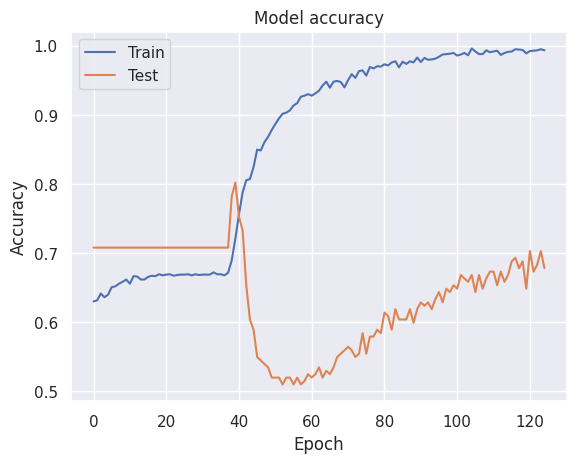

In [27]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [28]:
eval = model.evaluate(test_dataset)

101/101 [==============================] - 1s 5ms/step - loss: 3.4863 - accuracy: 0.6782


In [29]:
sound, sample_rate = librosa.load("/content/drive/MyDrive/Master-Dataset/what_a_gwan.wav")
audio_trimmed, _ = librosa.effects.trim(sound, top_db=24)

In [30]:
target_image = get_spectrogram_image(audio_trimmed)
target_image = tf.expand_dims(target_image, 0)
target_image.shape

TensorShape([1, 224, 512, 3])

In [31]:
sound1, sample_rate1 = librosa.load("/content/drive/MyDrive/Master-Dataset/what_a_gwan.wav")
audio_trimmed1, _ = librosa.effects.trim(sound1, top_db=24)

In [32]:
ref_image = get_spectrogram_image(audio_trimmed1)
ref_image = tf.expand_dims(ref_image, 0)

In [33]:
ans = model.predict([ref_image, target_image])

1/1 [==============================] - 0s 335ms/step


In [34]:
ans[0][0]

0.6209546

In [38]:
# model.save("/content/drive/MyDrive/model.h5")